# Imports and Function Definition

In [ ]:
import re, os
import shutil
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist



print('TF Version:', tf.__version__)

import seaborn as sns
from sklearn.metrics import (confusion_matrix,
                             classification_report,
                             precision_recall_curve)

2026-01-12 19:56:15.958170: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-12 19:56:16.448504: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-12 19:56:18.684236: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


TF Version: 2.20.0


## Data Loading

In [48]:
IMG_DIMS = (128, 128)
BATCH_SIZE = 32
IMG_SHAPE = IMG_DIMS + (3,)
classes = ['no_damage', 'damage']
AUTOTUNE = tf.data.AUTOTUNE

def prepare_train_and_val_datasets(base_dir):
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(base_dir, "train"),
        class_names=['no_damage', 'damage'],
        seed=42,
        shuffle=True,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(base_dir, "val"),
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
        shuffle=False
    )

    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(base_dir, "test"),
        class_names=['no_damage', 'damage'],
        shuffle=False,
        image_size=IMG_DIMS,
        batch_size=128,
    )

    train_ds = train_ds.prefetch(buffer_size=25)
    val_ds = val_ds.prefetch(buffer_size=25)
    test_ds = test_ds.prefetch(buffer_size=25)

    return train_ds, val_ds, test_ds




## Augementation and Data Preparation

In [3]:
def get_augmentation_layer() -> tf.keras.Sequential:
    """Creates a Keras Sequential model that performs random augmentations."""
    return tf.keras.Sequential([
        layers.RandomFlip('horizontal'),
        layers.RandomFlip('vertical'),
        layers.RandomRotation(0.3),
        layers.RandomZoom(0.2),
        layers.RandomTranslation(0.1, 0.1),
        layers.RandomContrast(0.2),
        layers.RandomBrightness(0.2),

        # Add Gaussian noise to simulate sensor noise
        layers.GaussianNoise(0.01),
    ], name="data_augmentation")


In [4]:
def prepare_dataset(ds, augment=False):
    """Applies caching, shuffling, augmentation, and prefetching."""
    ds = ds.cache()
    if augment:
        aug_layer = get_augmentation_layer()
        ds = ds.map(lambda x, y: (aug_layer(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)
    ds = ds.shuffle(BATCH_SIZE*3).prefetch(AUTOTUNE)
    return ds


## BaseLine Model

In [5]:
def build_baseline_model(input_shape=IMG_SHAPE) -> tf.keras.Model:
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, 3, activation='relu')(inputs)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)   # binary output
    model = models.Model(inputs, outputs, name="baseline_cnn")
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'precision', 'recall'])
    return model


## Transfer Models

In [6]:
def build_transfer_model(model_name='MobileNetV2',
                         input_shape=IMG_SHAPE,
                         fine_tune_at=None) -> tf.keras.Model:
    """
    Function for returning Transfer Learning models.
    model_name: Any valid tf.keras.applications name (VGG16, MobileNetV2, etc.)
    fine_tune_at: Layer index to start unfreezing. If None, whole base is frozen.
    """

    # Get the keras application for the specific model
    keras_app = getattr(tf.keras.applications, model_name)

    # Get the correct module to extract model specific preprocessing
    parent_module = keras_app.__module__.split('.')[-1]
    preprocess_func = getattr(tf.keras.applications, parent_module).preprocess_input

    # Load the pretrained base 
    base_model = keras_app(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )

    # Handling freezing
    if fine_tune_at is None:
        base_model.trainable = False
    else:
        base_model.trainable = True
        # Freeze early layers
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False


    # Contruct final transfer model
    inputs = layers.Input(shape=input_shape)
    x = get_augmentation_layer()(inputs)
    x = preprocess_func(x)
    x = base_model(x, training=False)        
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs, name=f"transfer_{model_name}")

    # Use a lower learning rate for transfer learning 
    lr = 1e-4 if fine_tune_at else 1e-3
    model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'precision', 'recall']
                  )
    return model


## Callbacks

In [7]:
def get_callbacks(patience_es=5, patience_lr=3):
    return [
        callbacks.EarlyStopping(monitor='val_loss',
                                patience=patience_es,
                                restore_best_weights=True),

        callbacks.ReduceLROnPlateau(monitor='val_loss',
                                    factor=0.5,
                                    patience=patience_lr,
                                    min_lr=1e-6)
    ]


## Model Training

In [8]:
def train_model(model, train_ds, val_ds, epochs=60):
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=get_callbacks(),
        verbose=1
    )
    return history


In [ ]:


def save_pickle(data, filename="histories.pkl"):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)

def load_pickle(filename="histories.pkl"):
    with open(rb) as f:
        return pickle.load(f)

## Training Monitoring


In [11]:
def plot_learning_curves(history, title="Experiment"):
    """
    Diagnostic tool to check for overfitting/underfitting.
    """
    epochs = range(len(history.history['loss']))
    metrics = ['loss', 'accuracy', 'precision', 'recall']
    
    plt.figure(figsize=(15, 10))
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        plt.plot(epochs, history.history[metric], label=f'Train {metric}')
        plt.plot(epochs, history.history[f'val_{metric}'], label=f'Val {metric}')
        plt.title(f'{title}: {metric.capitalize()}')
        plt.legend()
    plt.tight_layout()
    plt.show()

## Evaluation 

In [12]:
def plot_final_evaluation(model, test_ds, fname=None):
    """
    Performs final evaluation on test data.
    Focuses on the Confusion Matrix and class-specific Recall.
    """
    # 1. Collect true labels and predictions
    y_true = np.concatenate([y for x, y in test_ds], axis=0)
    y_probs = model.predict(test_ds)
    y_pred = (y_probs > 0.5).astype(int)

    # 2. Print the Scientific Summary
    print("--- EVALUATION SUMMARY ---")
    print(classification_report(y_true, y_pred, target_names=['No Damage', 'Damage']))

    # 3. Plot Normalized Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues', 
                xticklabels=['No Damage', 'Damage'], 
                yticklabels=['No Damage', 'Damage'])
    plt.title(f'Confusion Matrix: {model.name}')
    plt.ylabel('Actual Status')
    plt.xlabel('Predicted Status')

    if fname:
        plt.savefig(fname)
    plt.show()



def plot_precision_recall(model, test_ds, fname=None):
    """
    Visualizes the trade-off between Precision and Recall.
    Crucial for proving the model's reliability in disaster scenarios.
    """
    y_true = np.concatenate([y for x, y in test_ds], axis=0)
    y_probs = model.predict(test_ds)
    
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    
    plt.figure(figsize=(7, 5))
    plt.plot(recall, precision, color='darkorange', lw=2)
    plt.fill_between(recall, precision, alpha=0.2, color='orange')
    plt.xlabel('Recall (Ability to find all damage)')
    plt.ylabel('Precision (Ability to be correct when finding damage)')
    plt.title(f'Precision-Recall Curve: {model.name}')
    plt.grid(True)

    if fname:
        plt.savefig(fname)
    plt.show()

In [13]:
def get_metrics_summary(histories):
    summary = []
    for name, history in histories.items():
        # Get the metrics from the final epoch
        metrics = {
            "Model": name,
            "Val Accuracy":  history.history['val_accuracy'][-1],
            "Val Precision": history.history['val_precision'][-1],
            "Val Recall":    history.history['val_recall'][-1]
        }
        # Calculate F1 manually as it's often not in the history dict
        p = metrics["Val Precision"]
        r = metrics["Val Recall"]
        metrics["Val F1"] = 2 * (p * r) / (p + r + 1e-7)
        
        summary.append(metrics)
    
    return pd.DataFrame(summary)

# Load Data

In [ ]:
train_ds, val_ds, test_ds = prepare_train_and_val_datasets("data/Kaggle Set/")

Found 10000 files belonging to 2 classes.


I0000 00:00:1768247817.525639    3104 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5


Found 2000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [15]:
# Take one batch from the training set
for images, labels in train_ds.take(1):
    print(f"Image batch shape: {images.shape}")  # Expecting (BATCH_SIZE, Height, Width, 3)
    print(f"Label batch shape: {labels.shape}")  # Expecting (BATCH_SIZE,)
    print(f"First image pixel range: {tf.reduce_min(images)} to {tf.reduce_max(images)}")

Image batch shape: (32, 128, 128, 3)
Label batch shape: (32,)
First image pixel range: 0.0 to 255.0


2026-01-12 19:57:00.634644: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2026-01-12 19:57:01.382286: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


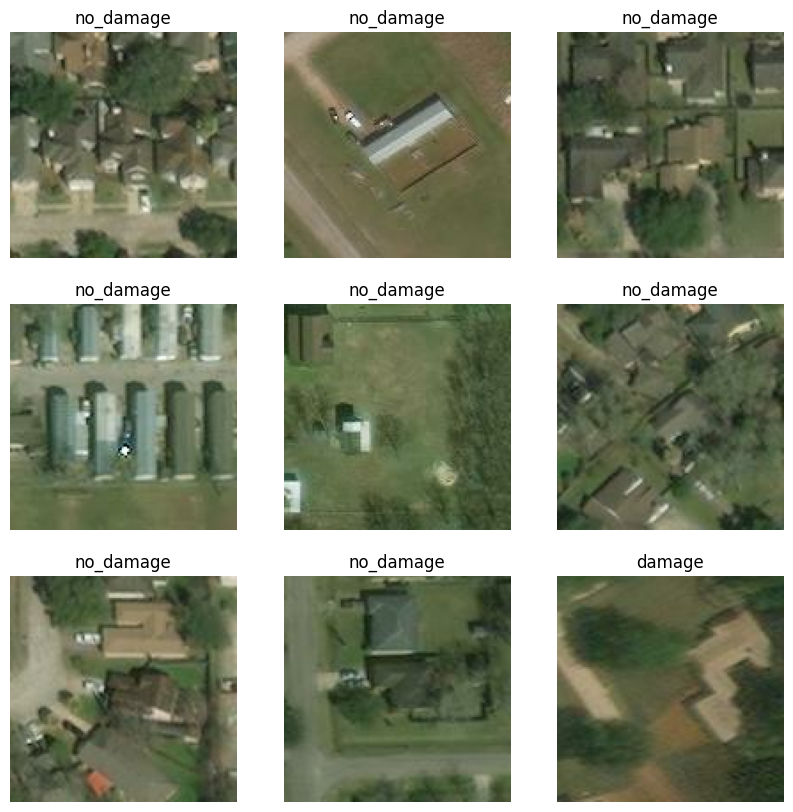

In [16]:

def visualize_dataset(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[int(labels[i])])
            plt.axis("off")
    plt.show()

# Run the visualization
visualize_dataset(train_ds, ['no_damage', 'damage'])

# Baseline

In [33]:
train_ds_aug = prepare_dataset(train_ds, augment=True)
val_ds_prep = prepare_dataset(val_ds, augment=False)

In [34]:
baseline = build_baseline_model()
baseline_hist = train_model(baseline, train_ds_aug, val_ds_prep)

Epoch 1/60


2026-01-12 17:51:03.375691: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:55: Filling up shuffle buffer (this may take a while): 75 of 96
2026-01-12 17:51:06.279180: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.
2026-01-12 17:51:06.281071: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291712 bytes after encountering the first element of size 6291712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


313/313 ━━━━━━━━━━━━━━━━━━━━ 57s 122ms/step - accuracy: 0.6940 - loss: 0.9326 - precision: 0.6953 - recall: 0.6906 - val_accuracy: 0.8440 - val_loss: 0.4619 - val_precision: 0.8991 - val_recall: 0.7750 - learning_rate: 0.0010
Epoch 2/60


2026-01-12 17:51:58.685301: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:55: Filling up shuffle buffer (this may take a while): 89 of 96


  3/313 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8142 - loss: 0.4823 - precision: 0.7872 - recall: 0.8403    

2026-01-12 17:52:00.187314: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 91ms/step - accuracy: 0.8267 - loss: 0.4192 - precision: 0.8132 - recall: 0.8482 - val_accuracy: 0.7605 - val_loss: 0.4524 - val_precision: 0.9155 - val_recall: 0.5740 - learning_rate: 0.0010
Epoch 3/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.8516 - loss: 0.3644 - precision: 0.8389 - recall: 0.8704 - val_accuracy: 0.8920 - val_loss: 0.2985 - val_precision: 0.8616 - val_recall: 0.9340 - learning_rate: 0.0010
Epoch 4/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 70ms/step - accuracy: 0.8514 - loss: 0.3641 - precision: 0.8392 - recall: 0.8694 - val_accuracy: 0.7905 - val_loss: 0.4090 - val_precision: 0.9180 - val_recall: 0.6380 - learning_rate: 0.0010
Epoch 5/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 74ms/step - accuracy: 0.8669 - loss: 0.3421 - precision: 0.8573 - recall: 0.8804 - val_accuracy: 0.8830 - val_loss: 0.3454 - val_precision: 0.8401 - val_recall: 0.9460 - learning_rate: 0.0010
Epoch 6/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 73ms/step - accuracy: 0

2026-01-12 17:56:54.346444: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:55: Filling up shuffle buffer (this may take a while): 92 of 96


  4/313 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - accuracy: 0.7773 - loss: 0.5383 - precision: 0.7313 - recall: 0.7562

2026-01-12 17:56:54.643226: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 70ms/step - accuracy: 0.8684 - loss: 0.3307 - precision: 0.8610 - recall: 0.8786 - val_accuracy: 0.8440 - val_loss: 0.3409 - val_precision: 0.8963 - val_recall: 0.7780 - learning_rate: 0.0010
Epoch 12/60
  2/313 ━━━━━━━━━━━━━━━━━━━━ 49s 160ms/step - accuracy: 0.7500 - loss: 0.3398 - precision: 0.8746 - recall: 0.7208  

2026-01-12 17:57:35.262234: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:55: Filling up shuffle buffer (this may take a while): 95 of 96
2026-01-12 17:57:35.262453: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


313/313 ━━━━━━━━━━━━━━━━━━━━ 39s 65ms/step - accuracy: 0.8903 - loss: 0.2753 - precision: 0.8778 - recall: 0.9068 - val_accuracy: 0.9035 - val_loss: 0.2581 - val_precision: 0.8726 - val_recall: 0.9450 - learning_rate: 0.0010
Epoch 13/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 73ms/step - accuracy: 0.8884 - loss: 0.2717 - precision: 0.8787 - recall: 0.9012 - val_accuracy: 0.8715 - val_loss: 0.3454 - val_precision: 0.8362 - val_recall: 0.9240 - learning_rate: 0.0010
Epoch 14/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 73ms/step - accuracy: 0.8988 - loss: 0.2586 - precision: 0.8899 - recall: 0.9102 - val_accuracy: 0.9035 - val_loss: 0.2502 - val_precision: 0.9147 - val_recall: 0.8900 - learning_rate: 0.0010
Epoch 15/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 72ms/step - accuracy: 0.9061 - loss: 0.2372 - precision: 0.8947 - recall: 0.9206 - val_accuracy: 0.9070 - val_loss: 0.2357 - val_precision: 0.9386 - val_recall: 0.8710 - learning_rate: 0.0010
Epoch 16/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 69ms/step - accurac

In [1]:
plot_learning_curves(baseline_hist, title="Baseline")

NameError: name 'plot_learning_curves' is not defined

2026-01-12 17:37:17.437987: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2026-01-12 17:37:17.668527: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[128,32,126,126]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,3,128,128]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2026-01-12 17:37:17.819417: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[128,64,61,61]{3,2,1,0}, u8[0]{0}) custom-call(f

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

2026-01-12 17:37:18.975819: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[80,32,126,126]{3,2,1,0}, u8[0]{0}) custom-call(f32[80,3,128,128]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2026-01-12 17:37:19.075865: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[80,64,61,61]{3,2,1,0}, u8[0]{0}) custom-call(f32[80,32,63,63]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivatio

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step
--- EVALUATION SUMMARY ---
              precision    recall  f1-score   support

   No Damage       0.50      1.00      0.67      1000
      Damage       0.00      0.00      0.00      1000

    accuracy                           0.50      2000
   macro avg       0.25      0.50      0.33      2000
weighted avg       0.25      0.50      0.33      2000



/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

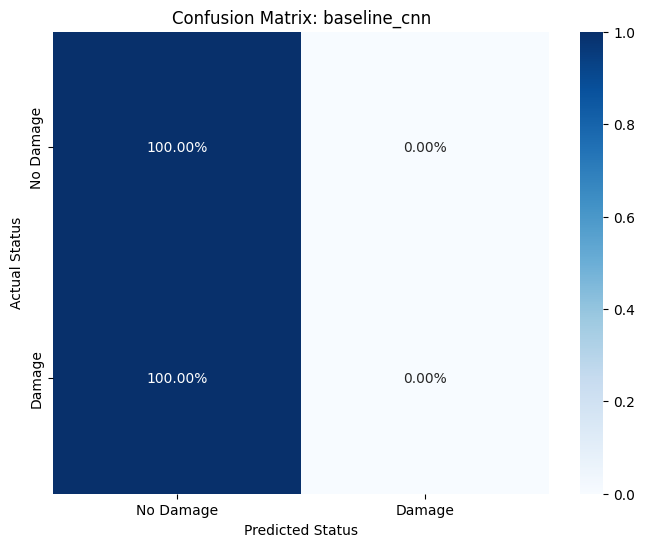

In [18]:
plot_final_evaluation(baseline, test_ds)

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

2026-01-12 17:37:52.502704: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


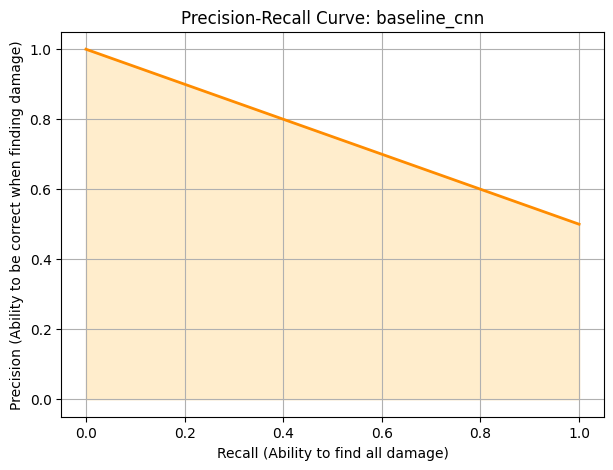

In [19]:
plot_precision_recall(baseline, test_ds)

# Transfer Learning

VGG16 - Classic
MobileNetV2 - LightWeight
EfficientNetB0 - Modern
ResNet50 - Heavy

In [17]:
#models_to_test = ['VGG16', 'MobileNetV2', 'EfficientNetB0', 'ResNet50']
models_to_test = ['ResNet50']
histories = {} 

for name in models_to_test:
    try:
        print(f"\n--- Initializing Experiment: {name} ---")
        
        # Build
        model = build_transfer_model(model_name=name)
        
        # Train
        print(f"Training {name}...")
        history = train_model(model, train_ds, val_ds)

        # Save the actual model file
        model.save(f"model_{name}_kag.keras",include_optimizer=False)

        # Save history
        save_pickle(history, filename=f"{name}_kag.pkl")
        
        # Save result
        histories[name] = history
        print(f"Successfully completed {name}.")
        
    except AttributeError:
        print(f"[ERROR]: Model '{name}' not found in tf.keras.applications. Skipping...")
    except Exception as e:
        print(f"[ERROR]: An unexpected error occurred with {name}: {e}. Skipping...")
        continue 

print("\n--- All experiments finished. ---")


--- Initializing Experiment: ResNet50 ---
Training ResNet50...
Epoch 1/60


2026-01-12 18:26:03.635024: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


313/313 ━━━━━━━━━━━━━━━━━━━━ 68s 175ms/step - accuracy: 0.8433 - loss: 0.3654 - precision: 0.8450 - recall: 0.8408 - val_accuracy: 0.9260 - val_loss: 0.2013 - val_precision: 0.9112 - val_recall: 0.9440 - learning_rate: 0.0010
Epoch 2/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 39s 55ms/step - accuracy: 0.9035 - loss: 0.2458 - precision: 0.9028 - recall: 0.9044 - val_accuracy: 0.9330 - val_loss: 0.1752 - val_precision: 0.9212 - val_recall: 0.9470 - learning_rate: 0.0010
Epoch 3/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 55ms/step - accuracy: 0.9083 - loss: 0.2345 - precision: 0.9077 - recall: 0.9090 - val_accuracy: 0.9325 - val_loss: 0.1676 - val_precision: 0.9278 - val_recall: 0.9380 - learning_rate: 0.0010
Epoch 4/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - accuracy: 0.9135 - loss: 0.2187 - precision: 0.9141 - recall: 0.9128 - val_accuracy: 0.9375 - val_loss: 0.1635 - val_precision: 0.9219 - val_recall: 0.9560 - learning_rate: 0.0010
Epoch 5/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - accuracy: 

In [45]:
df_results = get_metrics_summary(histories)

In [47]:
df_results


,Model,Val Accuracy,Val Precision,Val Recall,Val F1
0,VGG16,0.889299,0.863946,0.927007,0.894366
1,MobileNetV2,0.837638,0.897436,0.766423,0.826772
2,EfficientNetB0,0.896679,0.897810,0.897810,0.897810
3,ResNet50,0.922509,0.920290,0.927007,0.923636


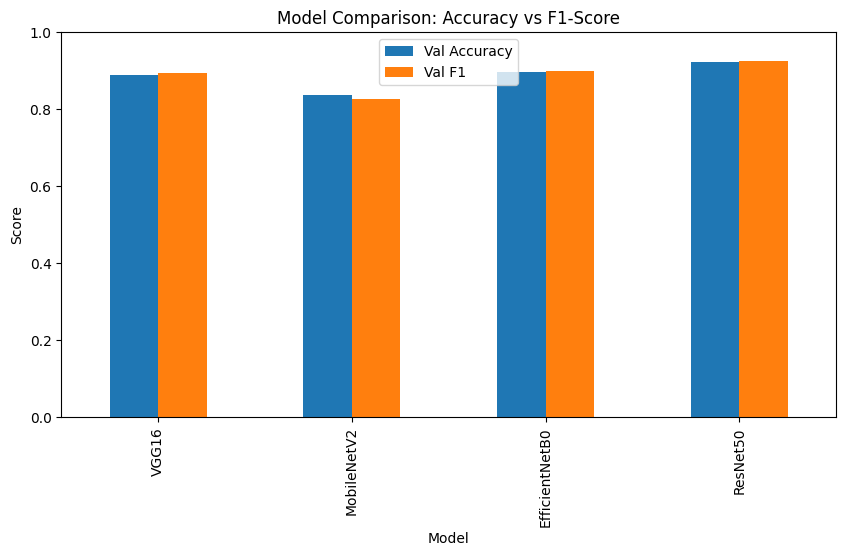

In [46]:
df_results.set_index("Model")[["Val Accuracy", "Val F1"]].plot(kind="bar", figsize=(10, 5))
plt.title("Model Comparison: Accuracy vs F1-Score")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.show()

# Evaluate ResNet50

In [17]:
ResNet50_model = load_model('model_ResNet50_kag.keras')


2026-01-12 19:58:07.172943: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 299ms/step
--- EVALUATION SUMMARY ---
              precision    recall  f1-score   support

   No Damage       0.95      0.95      0.95      1000
      Damage       0.95      0.95      0.95      1000

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000



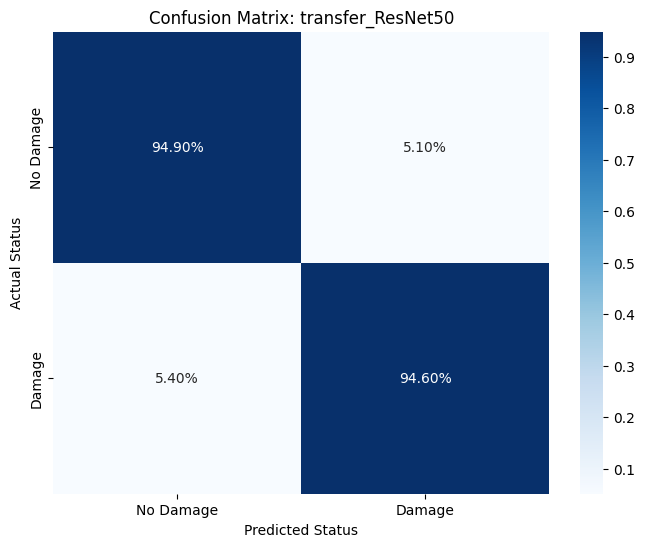

In [18]:
plot_final_evaluation(ResNet50_model, test_ds)
#plot_final_evaluation(ResNet50_model, test_ds, fname="cm_resnet50.png")

 1/16 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step

2026-01-12 19:58:36.046708: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step


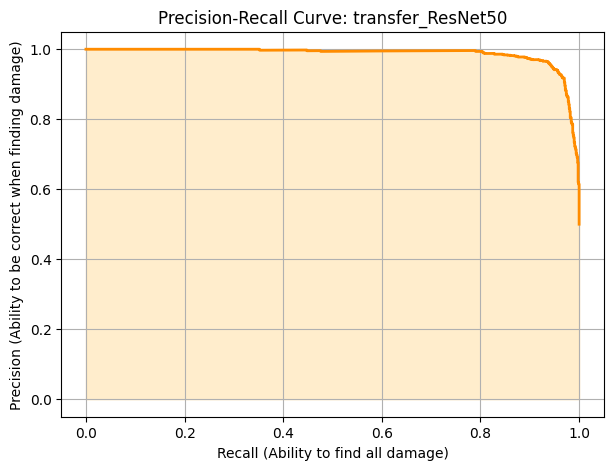

In [19]:
plot_precision_recall(ResNet50_model, test_ds)
#plot_precision_recall(ResNet50_model, test_ds, fname="resnet50_precrec")

In [21]:
def get_confident_errors(model, dataset, class_names):
    all_images = []
    all_labels = []
    all_probs = []

    # Collect data from the test set
    for images, labels in dataset:
        probs = model.predict(images, batch_size=16, verbose=0)
        all_images.append(images.numpy())
        all_labels.append(labels.numpy())
        all_probs.append(probs)

    all_images = np.concatenate(all_images)
    all_labels = np.concatenate(all_labels)
    all_probs = np.concatenate(all_probs).flatten()

    # Calculate absolute error (e.g., |0.99 - 0| = 0.99)
    errors = np.abs(all_probs - all_labels)
    
    # Get indices of the top 9 largest errors
    top_error_idx = np.argsort(errors)[-9:]
    
    return all_images[top_error_idx], all_labels[top_error_idx], all_probs[top_error_idx]

In [20]:
def plot_errors(images, labels, probs, class_names):
    plt.figure(figsize=(15, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        # Robust Rescaling: This brings any range back to [0, 1] for display
        img = images[i]
        img = (img - img.min()) / (img.max() - img.min() + 1e-7)
        plt.imshow(img)
        
        actual = class_names[int(labels[i])]
        pred_prob = probs[i]
        pred_label = class_names[1] if pred_prob > 0.5 else class_names[0]
        
        plt.title(f"Actual: {actual}\nPred: {pred_label} ({pred_prob:.4f})")
        plt.axis('off')
    plt.tight_layout()
    plt.show()



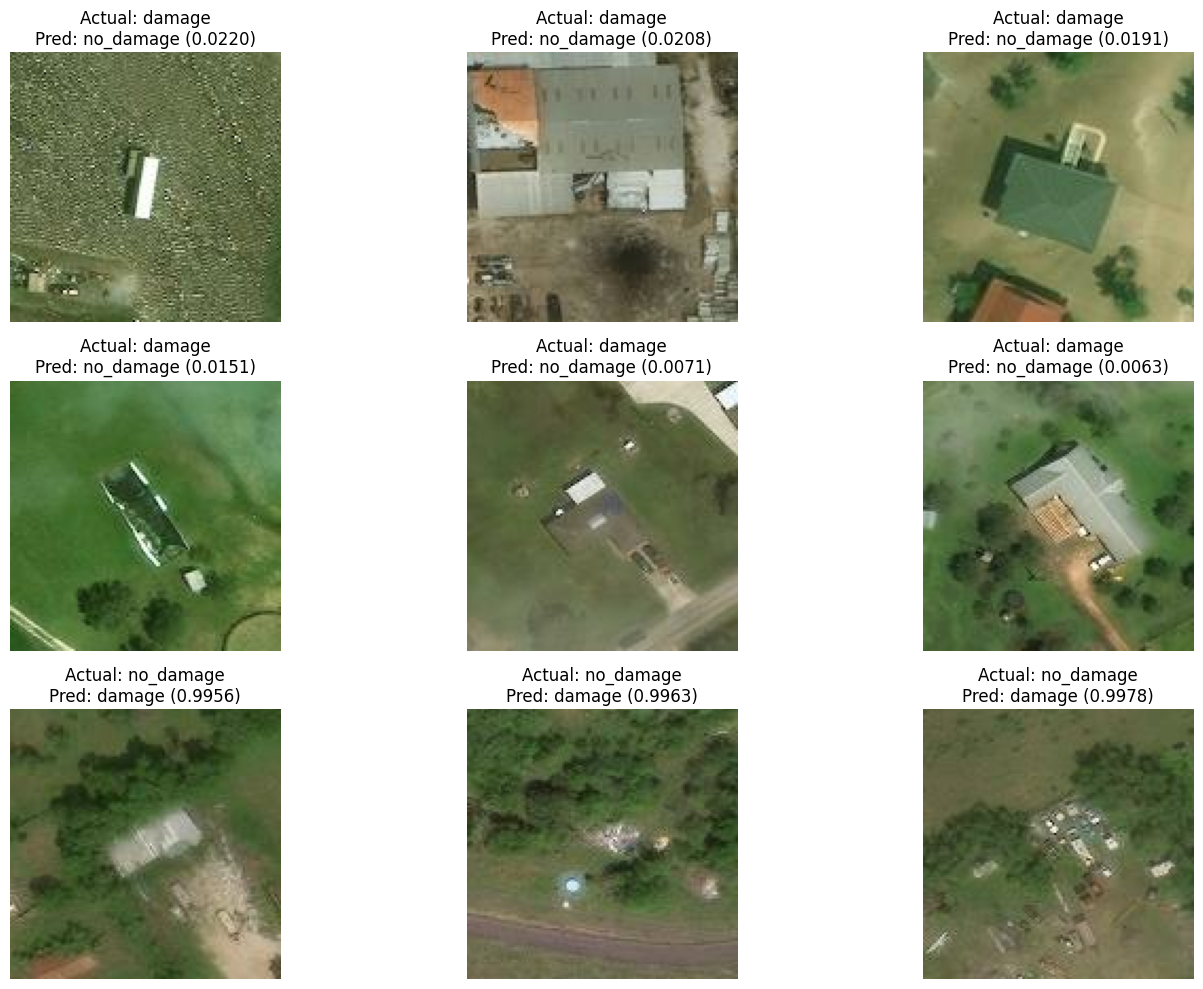

In [22]:
# Execution
images, labels, probs = get_confident_errors(ResNet50_model, test_ds, ['no_damage', 'damage'])
plot_errors(images, labels, probs, ['no_damage', 'damage'])

## Checking locational data leakage

In [44]:


def extract_coords(filename):
    # This regex looks for patterns like 29.1234_-95.1234 or similar
    coords = re.findall(r"[-+]?\d*\.\d+|\d+", filename)
    return [float(coords[0]), float(coords[1])] if len(coords) >= 2 else [0, 0]

def check_train_test_proximity(train_files, test_files):
    #Get all filenames
    train_files = os.listdir(train_files)
    test_files = os.listdir(test_files)

    #Extract Lat/Long into DataFrames
    df_train = pd.DataFrame([extract_coords(f) for f in train_files], columns=['lat', 'lon'])
    df_test = pd.DataFrame([extract_coords(f) for f in test_files], columns=['lat', 'lon'])

    #Calculate distance between every Test point and its nearest Train neighbor

    distances = cdist(df_test, df_train, metric='euclidean')
    min_distances = distances.min(axis=1)

    print(f"Average 'Distance' to nearest training neighbor: {min_distances.mean():.6f}")
    print(f"Percentage of test images 'dangerously close' (< 0.001): {(min_distances < 0.001).mean():.2%}")

check_train_test_proximity(train_files="data/Kaggle Set/train/damage", test_files="data/Kaggle Set/test/damage")

Average 'Distance' to nearest training neighbor: 0.000710
Percentage of test images 'dangerously close' (< 0.001): 88.90%


In [26]:
import glob
import pandas as pd
from scipy.spatial.distance import cdist

# Get ALL test files (damage + no_damage) sorted alphabetically
all_test_files = sorted(glob.glob("./data/test_hurricane/**/*.*", recursive=True))

# Extract coordinates for all 12,228 files
df_test_all = pd.DataFrame([extract_coords(f) for f in all_test_files], columns=['lat', 'lon'])

# Re-calculate distances against your full Training set
distances = cdist(df_test_all, df_train, metric='euclidean')
min_distances = distances.min(axis=1) 

print(f"Mask size: {len(min_distances)}")

Mask size: 12228


In [27]:
# Get all labels and predictions in order
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = ResNet50_model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype(int).flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

2026-01-11 02:00:42.918114: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [25]:
len(min_distances)

5895

In [28]:
# Ensure min_distances matches the length of y_true
# If you used a generator, make sure the file order is the same!
far_mask = min_distances >= 0.001

# Calculate the difference
leaked_acc = (y_true[~far_mask] == y_pred[~far_mask]).mean()
scientific_acc = (y_true[far_mask] == y_pred[far_mask]).mean()

print(f"Accuracy on Neighbors (Leaked): {leaked_acc:.2%}")
print(f"Accuracy on New Areas (Scientific): {scientific_acc:.2%}")

Accuracy on Neighbors (Leaked): 96.11%
Accuracy on New Areas (Scientific): 90.46%


# Geogrpahic split

In [28]:
def build_file_map(base_dir):
    data = []

    for directory in ['train', 'test', 'val']:
        for label in ['damage', 'no_damage']:
            folder_path = os.path.join(base_dir, directory, label)
            for filename in os.listdir(folder_path):
                # Use your existing coordinate extraction logic
                lat, lon = extract_coords(filename) 
                data.append({
                    'path': os.path.join(folder_path, filename),
                    'filename': filename,
                    'label': label,
                    'lat': lat,
                    'lon': lon
                })
    return pd.DataFrame(data)


df = build_file_map("data/Kaggle Set/")

In [33]:
df[df["label"] == "no_damage"].count()

path        7000
filename    7000
label       7000
lat         7000
lon         7000
dtype: int64

In [40]:
def geographic_split(df, train_pct=0.8, val_pct=0.1):
    train_list, val_list, test_list = [], [], []
    
    for label in ['damage', 'no_damage']:
        # Filter by class and sort by Longitude
        sub_df = df[df['label'] == label].sort_values('lon')
        
        n = len(sub_df)
        n_train = int(n * train_pct)
        n_val = int(n * val_pct)
        
        # Slice the sorted data
        train_list.append(sub_df.iloc[:n_train])
        val_list.append(sub_df.iloc[n_train:n_train + n_val])
        test_list.append(sub_df.iloc[n_train + n_val:])
        
    return pd.concat(train_list), pd.concat(val_list), pd.concat(test_list)

df_train, df_val, df_test = geographic_split(df)

In [41]:
df_train[df_train['label'] == 'damage'].count()

path        5600
filename    5600
label       5600
lat         5600
lon         5600
dtype: int64

In [42]:


def create_split_folders(df, split_name):
    for _, row in df.iterrows():
        # Target: data/split_name/label/filename
        dest_dir = f"./data/GeoSplit/{split_name}/{row['label']}"
        os.makedirs(dest_dir, exist_ok=True)
        shutil.copy(row['path'], os.path.join(dest_dir, row['filename']))

create_split_folders(df_train, 'train')
create_split_folders(df_val, 'val')
create_split_folders(df_test, 'test')

## Check train - test proximity again

In [45]:


check_train_test_proximity(train_files="data/GeoSplit/train/damage", test_files="data/GeoSplit/test/damage")


Average 'Distance' to nearest training neighbor: 0.263364
Percentage of test images 'dangerously close' (< 0.001): 0.00%


## Reload Data

In [49]:
train_ds, val_ds, test_ds = prepare_train_and_val_datasets("data/GeoSplit/")
train_ds_aug = prepare_dataset(train_ds, augment=True)
val_ds_prep = prepare_dataset(val_ds, augment=False)

Found 10172 files belonging to 2 classes.
Found 1268 files belonging to 2 classes.
Found 1281 files belonging to 2 classes.


## Retrain ResNet50

In [50]:
name = 'ResNet50'
print(f"\n--- Initializing Experiment: {name} ---")
        
# Build
model = build_transfer_model(model_name=name)

# Train
print(f"Training {name}...")
history = train_model(model, train_ds, val_ds)

# Save the actual model file
model.save(f"model_{name}_kag.keras",include_optimizer=False)

# Save history
save_pickle(history, filename=f"{name}_kag.pkl")


print(f"Successfully completed {name}.")


--- Initializing Experiment: ResNet50 ---
Training ResNet50...
Epoch 1/60
318/318 ━━━━━━━━━━━━━━━━━━━━ 43s 79ms/step - accuracy: 0.8407 - loss: 0.3727 - precision: 0.8467 - recall: 0.8431 - val_accuracy: 0.9219 - val_loss: 0.1908 - val_precision: 0.8974 - val_recall: 0.9589 - learning_rate: 0.0010
Epoch 2/60
318/318 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.8999 - loss: 0.2558 - precision: 0.8995 - recall: 0.9067 - val_accuracy: 0.9377 - val_loss: 0.1467 - val_precision: 0.9313 - val_recall: 0.9498 - learning_rate: 0.0010
Epoch 3/60
318/318 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - accuracy: 0.9117 - loss: 0.2354 - precision: 0.9101 - recall: 0.9192 - val_accuracy: 0.9409 - val_loss: 0.1461 - val_precision: 0.9230 - val_recall: 0.9665 - learning_rate: 0.0010
Epoch 4/60
318/318 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.9166 - loss: 0.2152 - precision: 0.9195 - recall: 0.9184 - val_accuracy: 0.9456 - val_loss: 0.1330 - val_precision: 0.9362 - val_recall: 0.9604 - learning_rate:

NameError: name 'save_pickle' is not defined

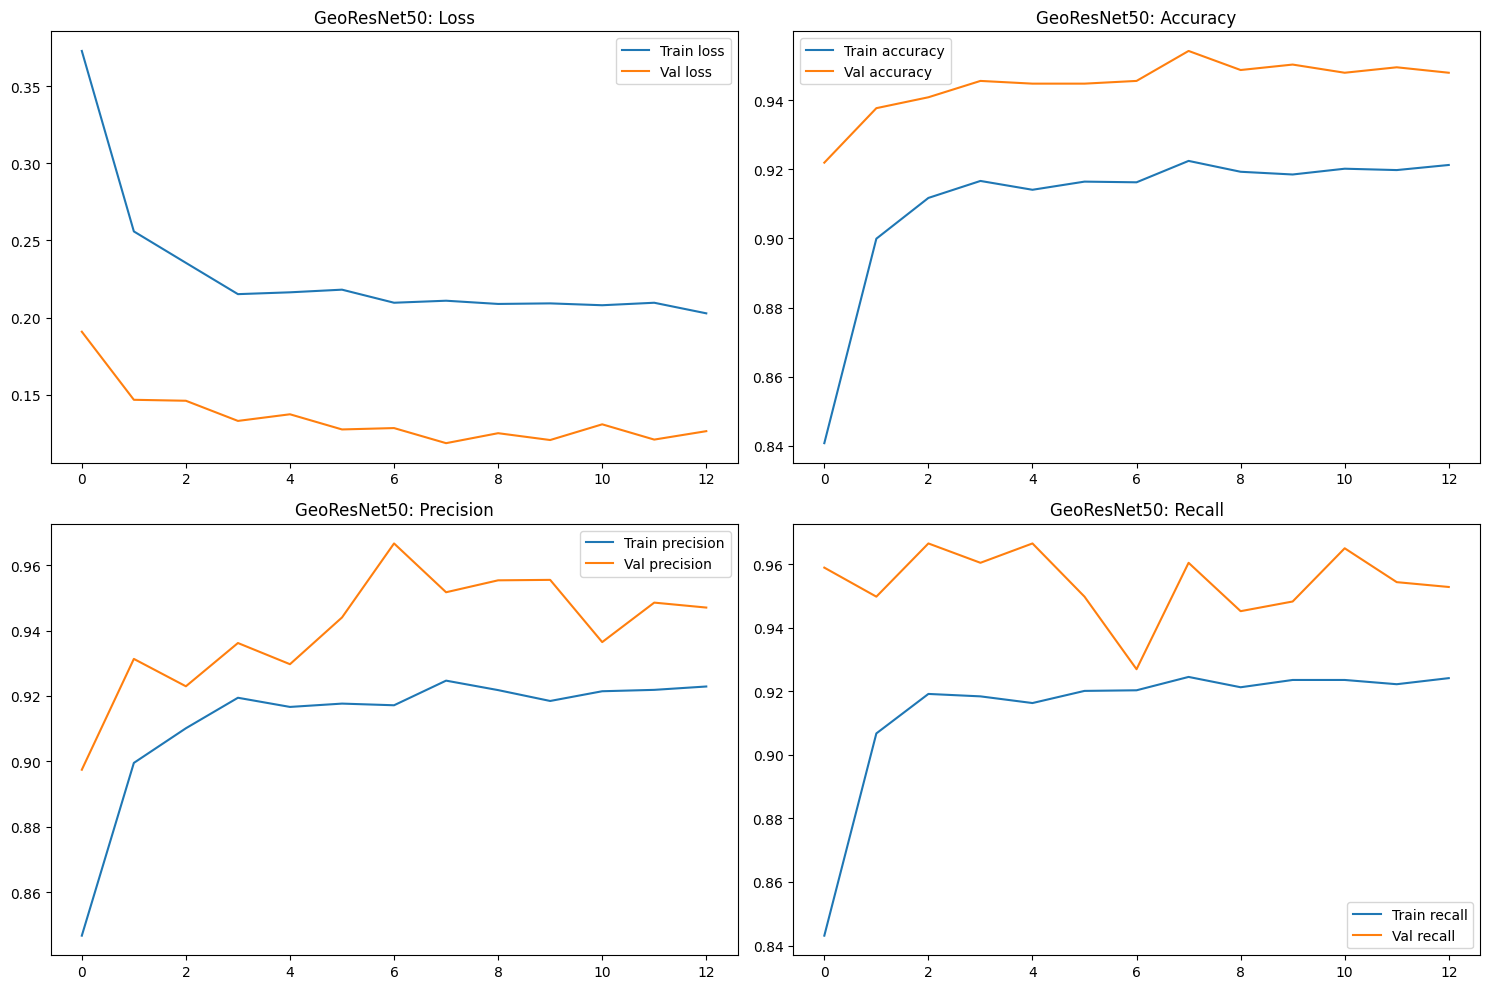

In [53]:
plot_learning_curves(history, title="GeoResNet50")

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step


--- EVALUATION SUMMARY ---
              precision    recall  f1-score   support

   No Damage       0.89      0.94      0.91       621
      Damage       0.94      0.89      0.91       660

    accuracy                           0.91      1281
   macro avg       0.91      0.91      0.91      1281
weighted avg       0.91      0.91      0.91      1281



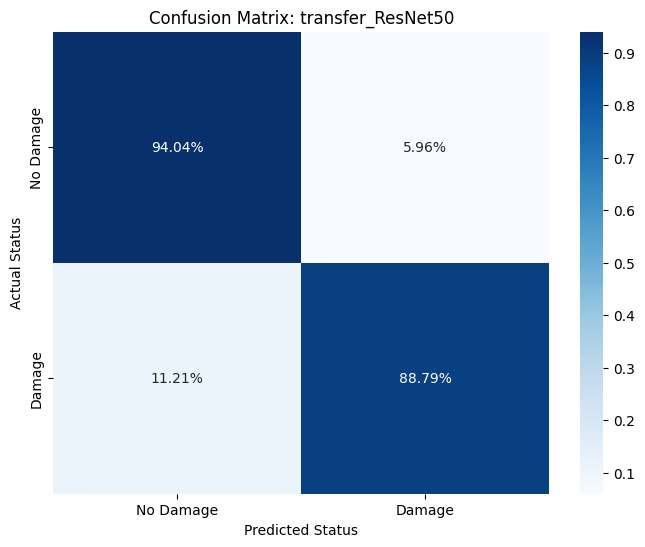

In [55]:
plot_final_evaluation(model, test_ds, fname="GeoResNet50 - CM.png")

 1/11 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step

2026-01-12 20:50:10.114471: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


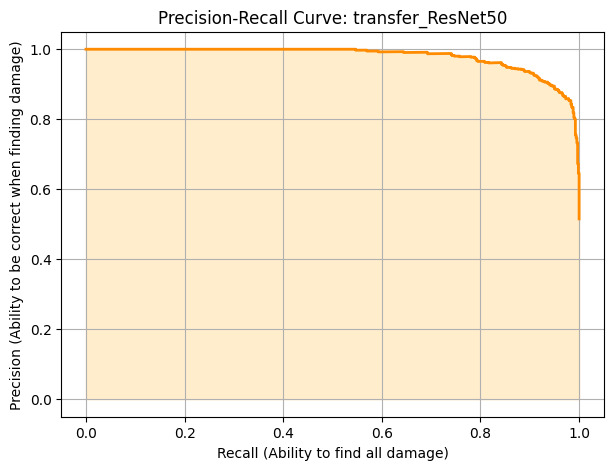

In [56]:
plot_precision_recall(model, test_ds, fname="GeoResNet50 - PreRec")